Another first try of the metrics but with the grid CIs as well.

#

This notebook is all about coming up with ways to asses how good a job PyVBMC does. 

To start, we'll state the differential equation of interest, get integration working for that equation, and run a PyVBMC optimize routine on it.


The differential equation:

$$\ddot{x} = -x -ax^b$$

generalized to deal with all values of b:

$$\ddot{x} = -x - sign(x)a|x|^b$$

$0<a\leq0.5$

 $1\leq b \leq 5$

In [97]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [98]:
def diffyqs(X, t, a,b):
    x, vx = X[0], X[1]
    dx = vx
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dx, dv]

initial_condition = [0.0, 3.5]
t = np.arange(0,10,0.05)

a = 0.2
b = 2.0
sol = odeint(diffyqs, initial_condition, t, args=(a,b))

x_true = sol[:,1]

a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

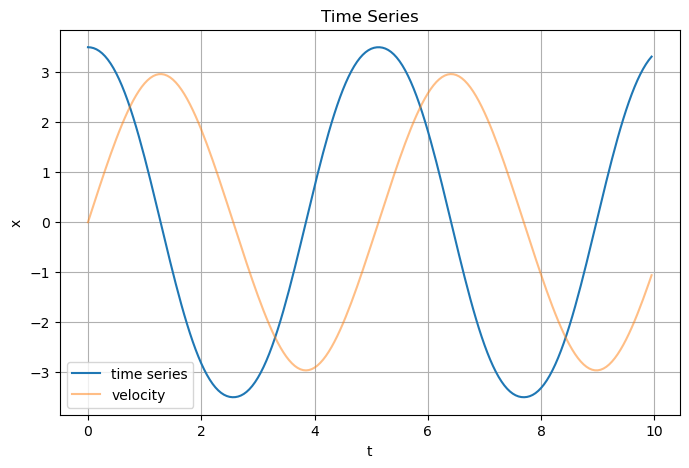

In [99]:
def plot_ts(t,ts,v, mode = 0):
    plt.figure(figsize=(8,5))
    if mode == 0:
        plt.plot(t,ts)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.grid()
        plt.show()
    else:
        plt.plot(t,ts, label = 'time series')
        plt.plot(t,v, label = 'velocity', alpha = 0.5)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend()
        plt.grid()
        plt.show()

plot_ts(t,sol[:, 1],sol[:, 0],1)

In [100]:
def log_likelihood(theta):
    a,b = theta

    sol = odeint(diffyqs, initial_condition, t, args=(a,b)) # get solution of ODE with current choice of params
    
    return -np.sum((sol[:,1] - x_true)**2) # normal distribution sorta

In [101]:
D = 2  # 2-D since there are 2 params we're estimating

LB = np.full((1, D), a_min)  # Lower bounds
LB[0][1] = b_min
UB = np.full((1, D), a_max)  # Upper bounds
UB[0][1] = b_max

PLB = np.copy(LB) + 0.05
PUB = np.copy(UB) - 0.05

x0 = np.full((1, D), 0.11) # starting point for inference   # 1.5 * np.ones((1, D))
x0[0][1] = 3.5

print(LB,PLB,PUB,UB,'x0:',x0)

[[0. 1.]] [[0.05 1.05]] [[0.45 4.95]] [[0.5 5. ]] x0: [[0.11 3.5 ]]


In [102]:
prior1 = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "display": "off"
}

#vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) # initialize VMBC object

In [103]:
#vp, results = vbmc.optimize(); # do optimization (might take a while)

In [104]:
#vp.plot();

Now that we have a Variational Posterior, we can think about defining a metric for it.

In [105]:
def euclidean_metric(vp,truth_array, n_samples = int(1e6)): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)
    """
    Xs, _ = vp.sample(n_samples) # sample vp
    # scaler = StandardScaler() # create scaler (don't bother centering)
    # scaler = MinMaxScaler(feature_range=(0,1))
    scaler = MinMaxScaler()
    scaler.fit(Xs)                     # fit scaler to samples
    scaled_data = scaler.transform(Xs) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    return np.linalg.norm(mean-truth_scaled) # return distance between mean and truth

# call the function on our current example
#euclidean_metric(vp,np.array([[a,b]]))

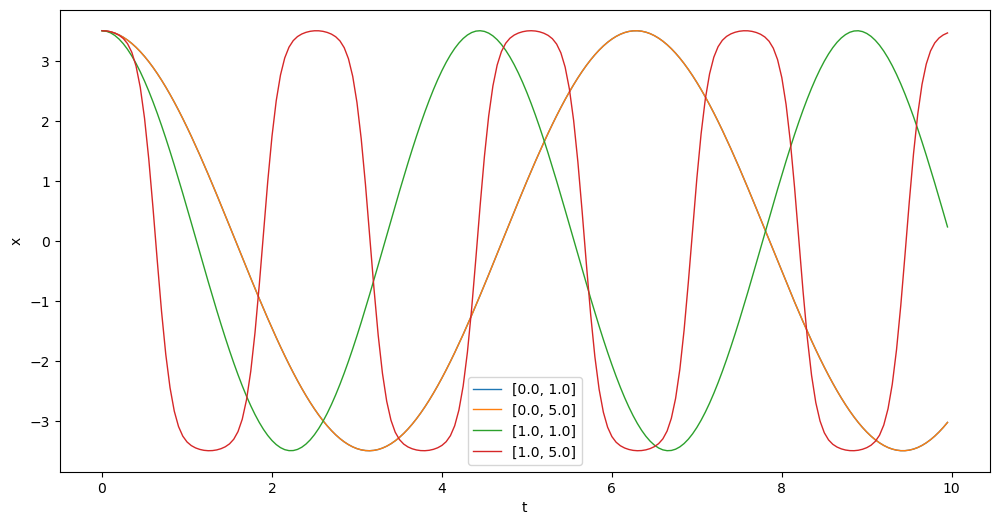

In [106]:
points = []
solutions = []
N = 2
grid = np.zeros((N,N))
for i,a in enumerate(np.linspace(0.0,1.0,N)):
    for j,b in enumerate(np.linspace(1.0,5.0,N)):
        points.append([a,b])
        sol = odeint(diffyqs, initial_condition, t, args=(a,b))
        x_true = sol[:,1]
        solutions.append(x_true)  

#solutions = solutions[0:5]
plt.figure(figsize=(12,6))
for i,sol in enumerate(solutions):
    plt.plot(t,sol, lw = 1,label = str(points[i]))
plt.xlabel('t')
plt.ylabel('x')
plt.legend()  
plt.show()  

In [107]:
a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

list = []
for i,a in enumerate(np.linspace(a_min,a_max,5)):     # a will be y axis in grid
    for j,b in enumerate(np.linspace(b_min,b_max,N)):
        list.append([a,b])
print(list)

[[0.0, 1.0], [0.0, 5.0], [0.125, 1.0], [0.125, 5.0], [0.25, 1.0], [0.25, 5.0], [0.375, 1.0], [0.375, 5.0], [0.5, 1.0], [0.5, 5.0]]


# Heatmap data with euclidean metric

In [81]:
N = 2
grid = np.zeros((N,N))

grid2 = np.zeros((N,N))
means = []
metrics = []
solutions = []

true_a_b = []
for i,a in enumerate(np.linspace(a_min,a_max,N)):     # a will be y axis in grid
    for j,b in enumerate(np.linspace(b_min,b_max,N)): # b will be x axis in grid
        sol_true = odeint(diffyqs, initial_condition, t, args=(a,b))
        x_true = sol_true[:,1]
        solutions.append(x_true)
        vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
        vp, results = vbmc.optimize();
        means.append(vp.moments())
        metric = euclidean_metric(vp,np.array([[a,b]]))
        grid[i,j] = metric
        metrics.append(metric)
        true_a_b.append([a,b])

# print(means)
# print(metrics)
# print(true_a_b)

# scaler = StandardScaler()
# scaler.fit(means)
# scaled_data = scaler.transform(means)
# # mean_of_means_a = sum(means[:,0])/len(means[:,0])
# # mean_of_means_b = sum(means[:,1])/len(means[:,1])

# mean_of_means = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()])
# # mean_of_means = sum(means)/len(means)
# # true_a_b = [[0.0, 1.0], [0.0, 5.0], [0.125, 1.0], [0.125, 5.0], [0.25, 1.0], [0.25, 5.0], [0.375, 1.0], [0.375, 5.0], [0.5, 1.0], [0.5, 5.0]]
# truth_scaled = scaler.transform(true_a_b)



# for i,a in enumerate(np.linspace(a_min,a_max,5)):     # a will be y axis in grid
#     for j,b in enumerate(np.linspace(b_min,b_max,N)):
#         metric = np.linalg.norm(mean_of_means - truth_scaled)
#         grid2[i,j] = metric
    


np.array(grid).tofile('metrics_grid_new.csv', sep = ',')


# np.array(grid2).tofile('metrics_grid_changed_metric.csv', sep = ',')
#np.array(metrics).tofile('metrics.csv', sep = ',')

/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.273 +/-0.002.


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.267 +/-0.002.


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -6.570 +/-0.205.
Caution: Returned variational solution may have not converged.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -2696.464 +/-0.001.


In [68]:
# metrics = []

# for i in range(3):
#     sol_true = odeint(diffyqs, initial_condition, t, args=(0.5,2.0))
#     vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
#     vp, results = vbmc.optimize();
#     metric = euclidean_metric(vp,np.array([[0.5,2.0]]))
#     metrics.append(metric)

# print(metrics)


In [69]:
# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -2696.447 +/-0.001.
# /Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
#   current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
# /Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
#   current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -18.051 +/-0.001.
# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -18.046 +/-0.001.
# [71.37514457844503, 652.6199156385479, 652.016298147476]



# /Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
#   current_fitness_range = max(es.fit.fit) - min(es.fit.fit)
# /Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
#   current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
# /Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
#   current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -2795.122 +/-0.001.
# /Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
#   current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
# /Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
#   current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -2795.125 +/-0.001.
# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -2795.120 +/-0.001.
# [1.6895801368144998, 1.7453703539996415, 1.7689974304095644]


# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -2795.125 +/-0.001.
# 1.8514637343573954
# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -2795.122 +/-0.001.
# 1.7594420184259985
# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -2868.160 +/-0.001.
# 8.273913725859002
# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -2868.161 +/-0.001.
# 8.125437360480388
# Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
# Estimated ELBO: -2795.127 +/-0.001.
# 1.645213269721345

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -2795.120 +/-0.001.
3.7828747962715377


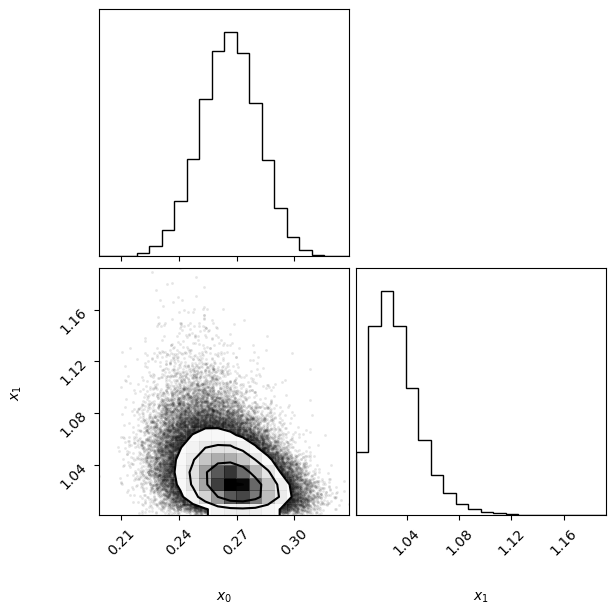

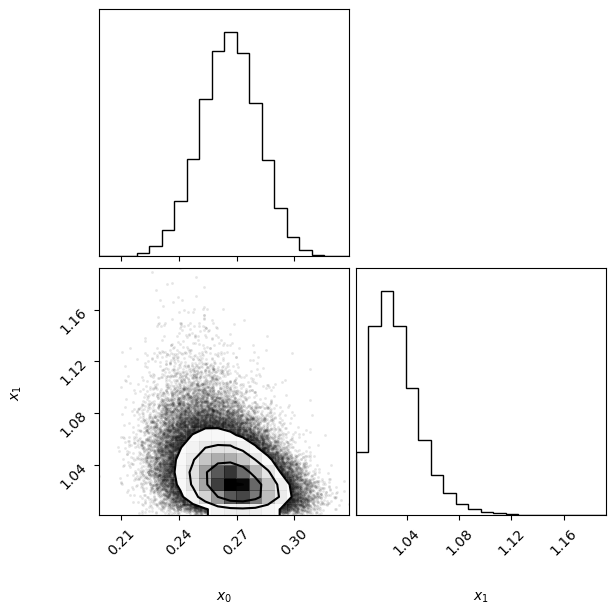

In [70]:
sol_true = odeint(diffyqs, initial_condition, t, args=(0.5,2.0))
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior1, options = options)
vp, results = vbmc.optimize();
metric = euclidean_metric(vp,np.array([[0.5,2.0]]))
print(metric)
vp.plot()

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -4.895 +/-0.001.
0.10275835584980712


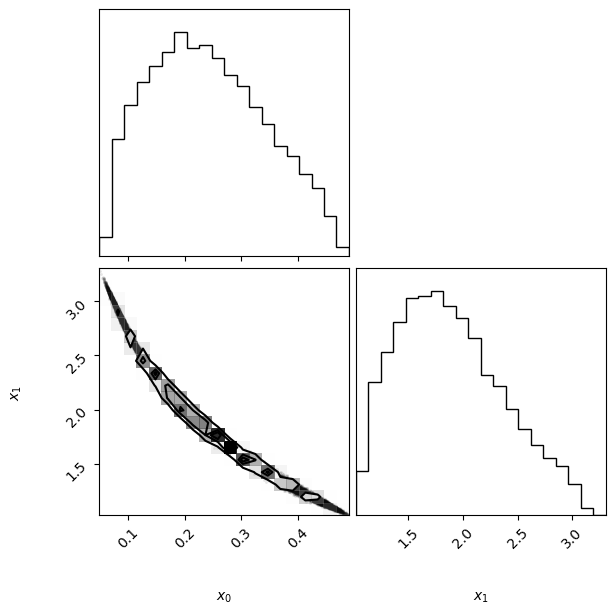

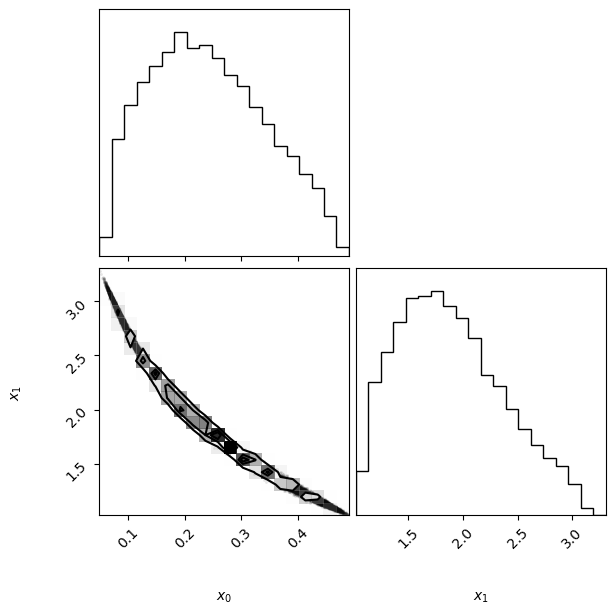

In [76]:
sol_true = odeint(diffyqs, initial_condition, t, args=(0.2,2.0))
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
vp, results = vbmc.optimize();
metric = euclidean_metric(vp,np.array([[0.2,2.0]]))
print(metric)
vp.plot()

In [77]:
vp.moments()

array([[0.24128802, 1.89448702]])

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -4.900 +/-0.001.
0.10469209832746613


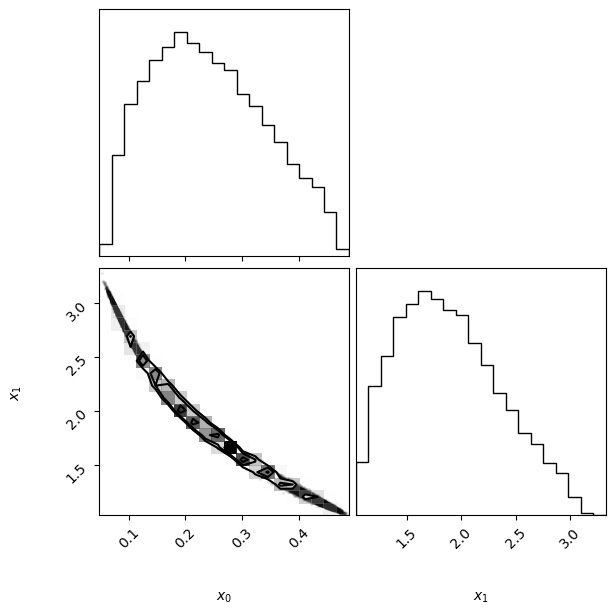

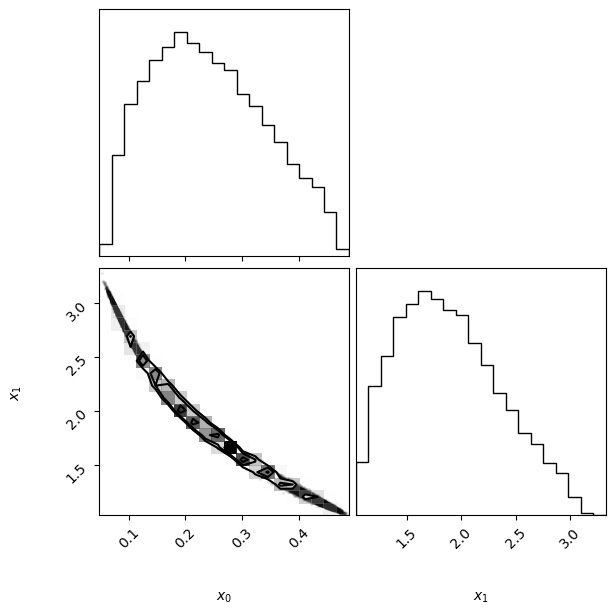

In [78]:
sol_true = odeint(diffyqs, initial_condition, t, args=(0.2,2.0))
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
vp, results = vbmc.optimize();
metric = euclidean_metric(vp,np.array([[0.2,2.0]]))
print(metric)
vp.plot()

In [79]:
vp.moments()

array([[0.24131858, 1.89194276]])

/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -18.050 +/-0.001.
37.56708853865998


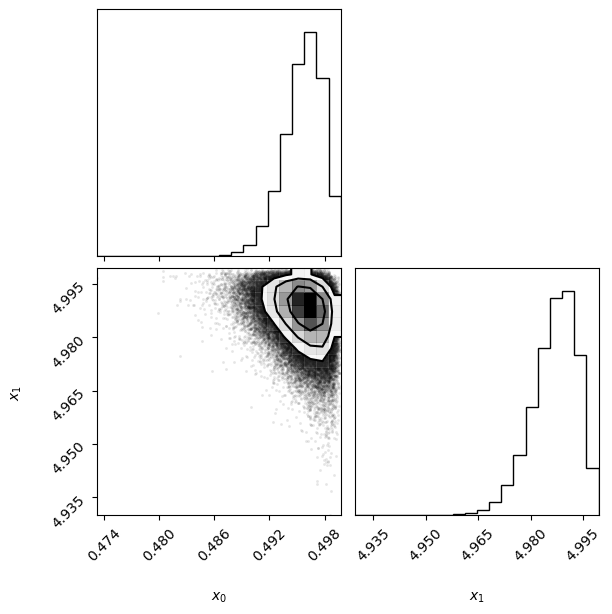

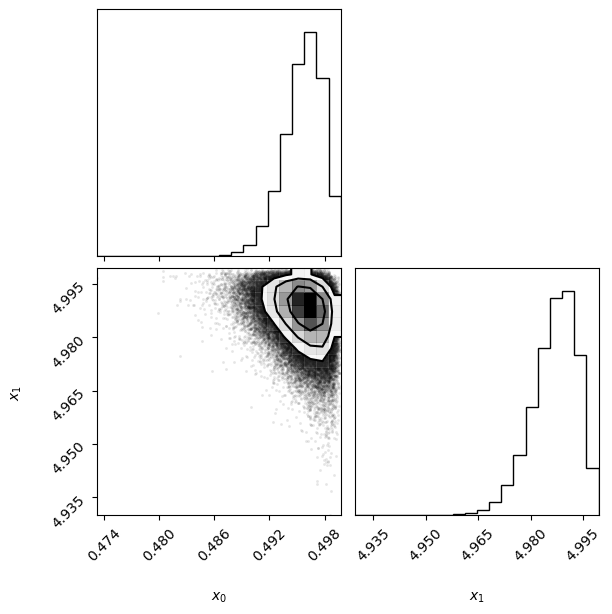

In [95]:
sol_true = odeint(diffyqs, initial_condition, t, args=(0.2,2.0))
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
vp, results = vbmc.optimize();
metric = euclidean_metric(vp,np.array([[0.2,2.0]]))
print(metric)
vp.plot()
# print(vp)

In [96]:
vp.moments()

array([[0.49561549, 4.98679976]])

In [92]:
# print(vp.pdf)
print(vp.mode)
print(vp.mode())

<bound method VariationalPosterior.mode of VariationalPosterior:
    self.D = 2,
    self.K = 50,
    self.mu = (2, 50) ndarray,
    self.w = (1, 50) ndarray,
    self.sigma = (1, 50) ndarray,
    self.lambd = 
        [[1.4124],
         [0.0713]] : ndarray,
    self.stats = <dict object at 0x1737cc140>,
    self._mode = None,
    self.bounds = None,
    self.eta = (1, 50) ndarray,
    self.optimize_lambd = True,
    self.optimize_mu = True,
    self.optimize_sigma = True,
    self.optimize_weights = True,
    self.parameter_transformer = ParameterTransformer:
        self.lb_orig = [[0., 1.]] : ndarray,
        self.ub_orig = [[0.5, 5. ]] : ndarray,
        self.type = [12., 12.] : ndarray,
        self.mu = [0., 0.] : ndarray,
        self.delta = [2.5631, 4.4828] : ndarray,
        self.scale = None,
        self.R_mat = None,
        self._bounded_transforms = <dict object at 0x1741d6640>,
        self.bounded_types = [12]>


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.4910113  2.11072446]


In [94]:
import scipy.stats as scs
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
pdf_simple = lambda x,y: vp.pdf(np.array([[x,y]]))
def CI_2D(vp,pdf,true_value,step = 0.05,n_samples = int(5e5)):
    # do sampling, take mode of samples
    Xs, _ = vp.sample(n_samples) # sample vp
    pdf_mode = scs.mode(Xs,keepdims = True)[0]
    a0,b0 = pdf_mode[0][0] - step, pdf_mode[0][0] + step
    a1,b1 = pdf_mode[0][1] - step, pdf_mode[0][1] + step
    I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
    print(I)
    def check_if_in_CI(true_value,a0,b0,a1,b1):
        if a0 <= true_value[0] and true_value[0] <= b0 \
            and a1 <= true_value[1] and true_value[1] <= b1:
            return False
        else:
            return True
    iter = 0
    while check_if_in_CI(true_value,a0,b0,a1,b1):
        I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
        a0 -= step
        b0 += step
        a1 -= step
        b1 += step
        #print("iter",iter )
        iter += 1
    return I
print("CI:",CI_2D(vp,pdf_simple,[0.5,0.5],0.1))


0.0
CI: 0.0


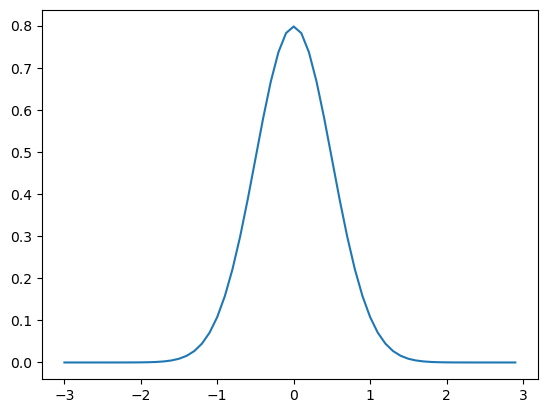

1 std CI:$ 0.6826894921370862


In [82]:
import scipy.stats as scs
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

sigma = 0.5
norm = scs.norm(loc = 0, scale = sigma)
plt.plot(np.arange(-3,3,0.1),norm.pdf(np.arange(-3,3,0.1)))
plt.show()

def CI_1D(pdf,true_value,step):
    x_range = np.arange(-5,5,0.1)
    y = np.array([pdf(x) for x in x_range])
    pdf_mode = x_range[np.argmax(y)]
    a,b = pdf_mode - step, pdf_mode + step
    I = 0
    I = integrate.quad(pdf, a, b)

    def check_if_in_CI(true_value,a,b):
        # if I == 0:
        #     I = integra
        if a <= true_value and true_value <= b:
            return False
        else:
            return True
    while check_if_in_CI(true_value,a,b):
        I = integrate.quad(pdf, a, b)[0]
        a -= step
        b += step
    return I

print("1 std CI:$",CI_1D(norm.pdf,0.5,0.01))

# example of how you could use it with PyVBMC
#simple_pdf = lambda x: vp.pdf(np.array([[x]]))
#CI_1D(simple_pdf,0.44,0.1)

# def CI_2D(pdf, true_values, steps):
#     x_range = np.arrange

